# Plan real-world action using counterfactual example analysis and causal analysis

This notebook demonstrates the use of the Responsible AI Toolbox to make decisions from diabetes progression data. It walks through the API calls necessary to create a widget with causal inferencing insights, then guides a visual analysis of the data.

* [Launch Responsible AI Toolbox](#Launch-Responsible-AI-Toolbox)
    * [Train a Model](#Train-a-Model)
    * [Create Model and Data Insights](#Create-Model-and-Data-Insights)
* [Take Real-World Action](#Take-Real-World-Action)
    * [What-If Counterfactuals Analysis](#What-If-Counterfactuals-Analysis)
    * [Causal Analysis](#Causal-Analysis)

## Launch Responsible AI Toolbox

The following section examines the code necessary to create the dataset. It then generates insights using the `responsibleai` API that can be visually analyzed.

### Train a Model
*The following section can be skipped. It loads a dataset for illustrative purposes.*

In [ ]:
import shap
import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

First, load the diabetes dataset and specify the different types of features. Then, clean it and put it into a dataframe with named columns.

In [ ]:
data = sklearn.datasets.load_diabetes()
target_feature = 'y'
continuous_features = data.feature_names
data_df = pd.DataFrame(data.data, columns=data.feature_names)

After loading and cleaning the data, split the datapoints into training and test sets. Assemble separate datasets for the training and test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df, data.target, test_size=0.2, random_state=7)

train_data = X_train.copy()
test_data = X_test.copy()
train_data[target_feature] = y_train
test_data[target_feature] = y_test
data.feature_names

Train a nearest-neighbors classifier on the training data.

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

### Create Model and Data Insights

In [ ]:
from raiwidgets import ModelAnalysisDashboard
from responsibleai import ModelAnalysis

To use Responsible AI Toolbox, initialize a ModelAnalysis object upon which different components can be loaded.

ModelAnalysis accepts the model, the train dataset, the test dataset, the target feature string, the task type string, and a list of strings of categorical feature names as its arguments.

In [ ]:
model_analysis = ModelAnalysis(model, train_data, test_data, target_feature, 'regression',
                               categorical_features=[])

Add the components of the toolbox that are focused on decision-making.

In [ ]:
# Counterfactuals: accepts total number of counterfactuals to generate, the range that their label should fall under, 
# and a list of strings of categorical feature names
model_analysis.counterfactual.add(total_CFs=20, desired_range=[50, 120])
# Causal Inference: determines causation between features
model_analysis.causal.add(treatment_features=['bmi', 'bp', 's2'])

Once all the desired components have been loaded, compute insights on the test set.

In [ ]:
model_analysis.compute()

Finally, visualize and explore the model insights. Use the resulting widget or follow the link to view this in a new tab.

In [ ]:
ModelAnalysisDashboard(model_analysis)

## Take Real-World Action

### What-If Counterfactuals Analysis

Let's imagine that the diabetes progression scores predicted by the model are used to determine medical insurance rates. If the score is greater than 120, there is a higher rate. Patient 43's model score of 268.08 results in this increased rate, and they want to know how they should change their health to get a lower rate prediction from the model (leading to lower insurance price).

The What-If counterfactuals component shows how slightly different feature values affect model predictions. This can be used to solve Patient 43's problem.

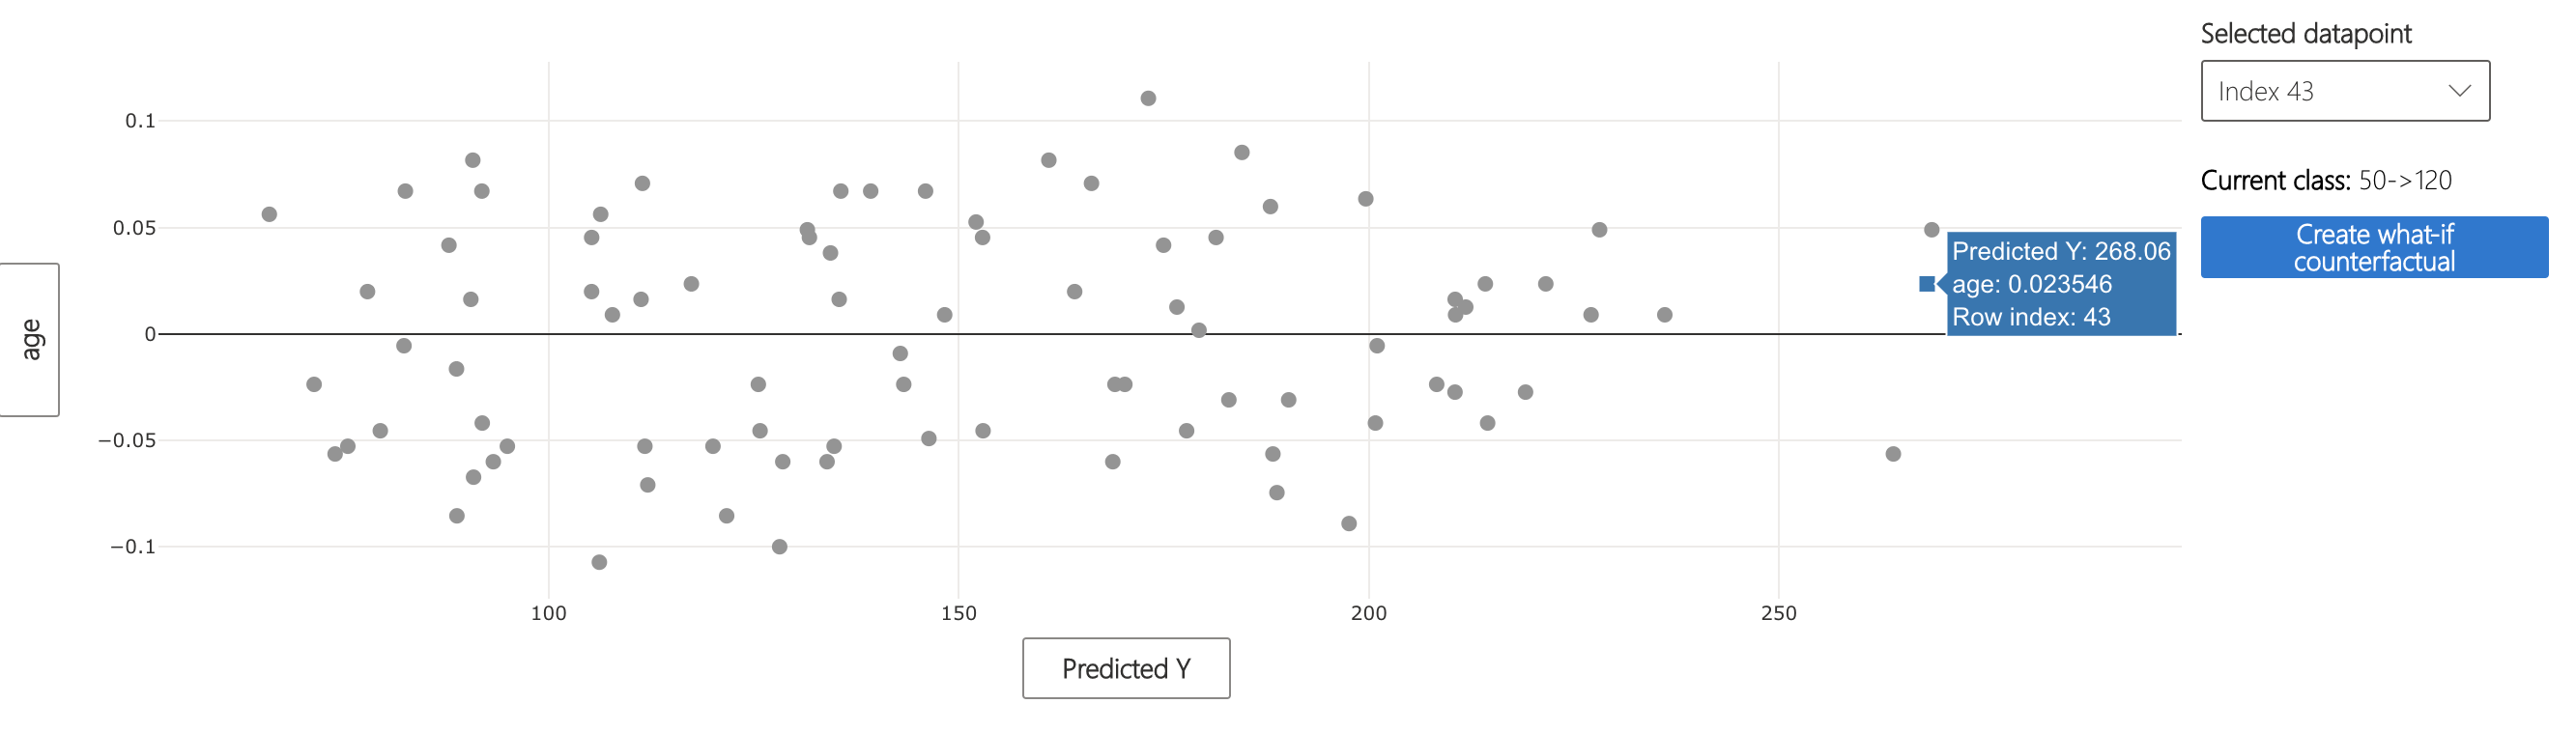

What can Patient 43 do to create the desired change? The top ranked features bar plot shows that `bmi` and `s5` are the best to perturb to bring the model score within 120.

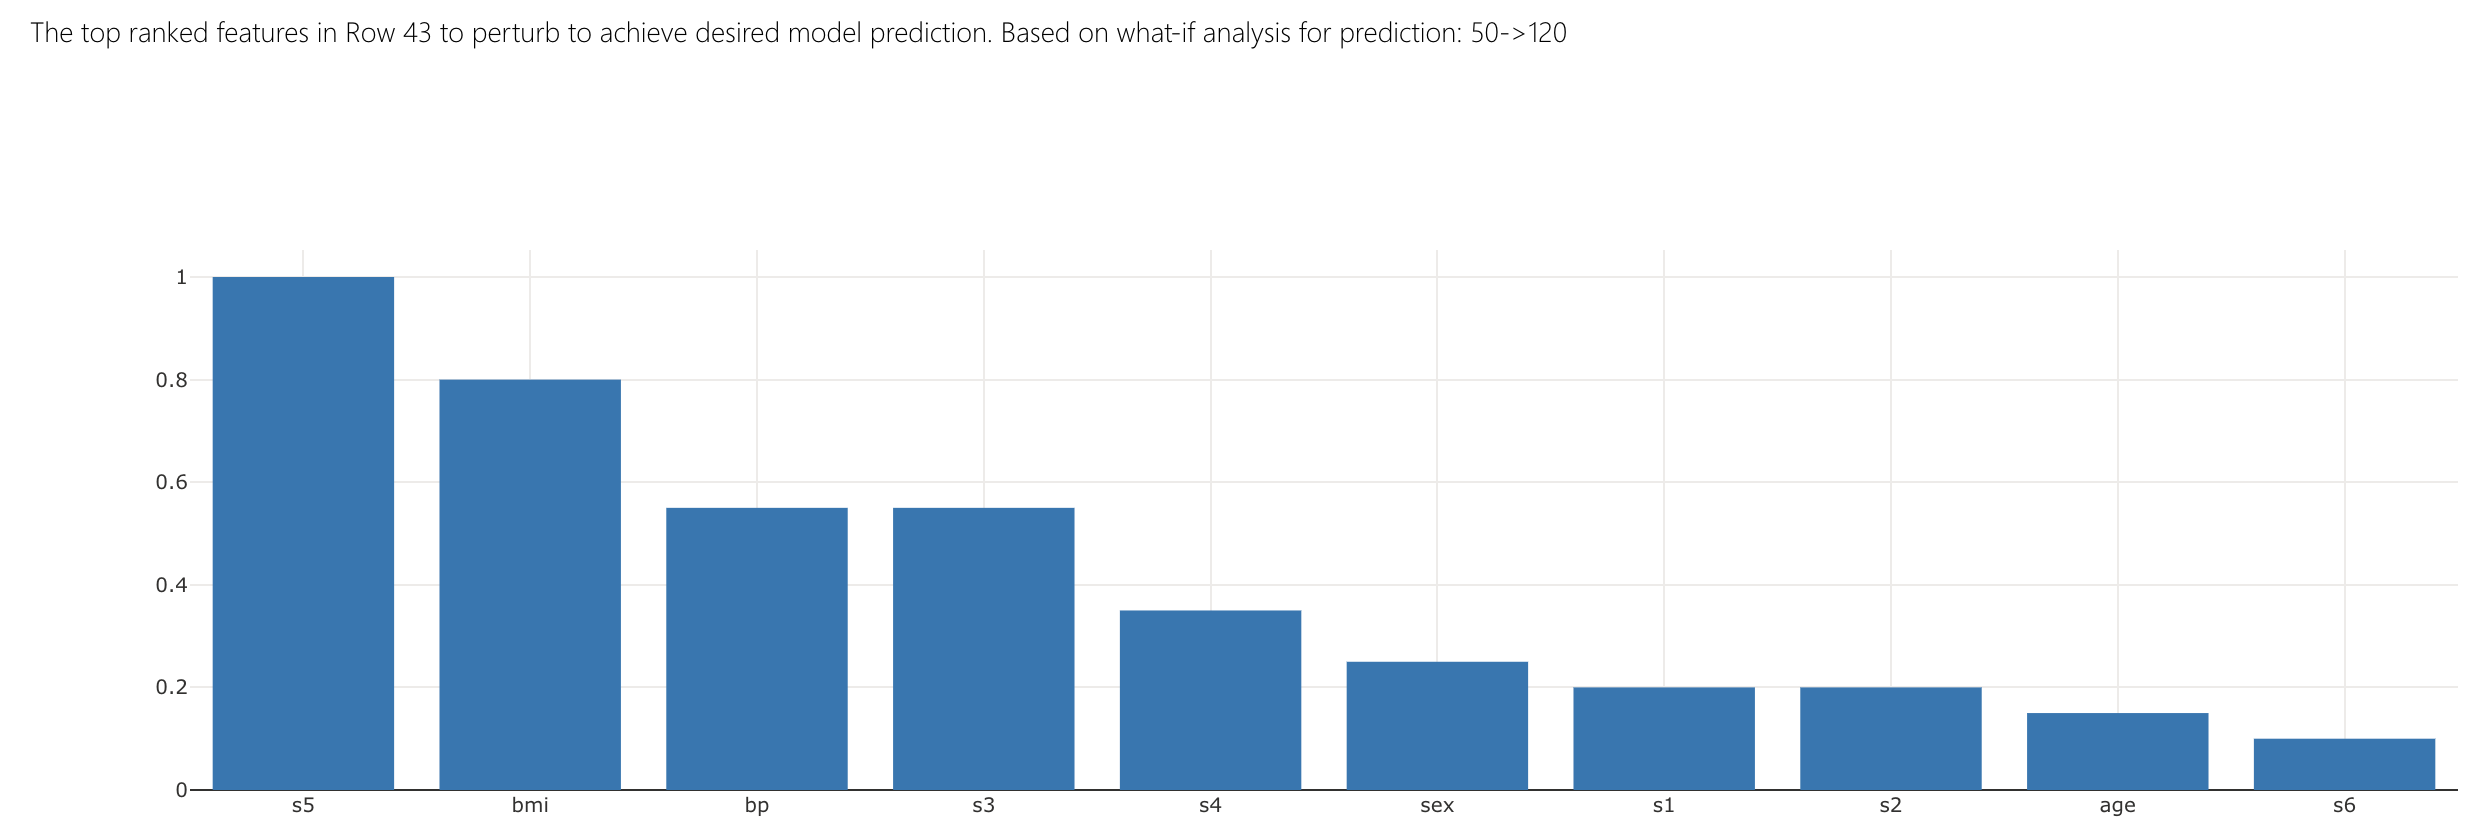

Let's see how that can be achieved. Change `bmi` to -0.04 and `s5` to -0.042 and see what the result is.

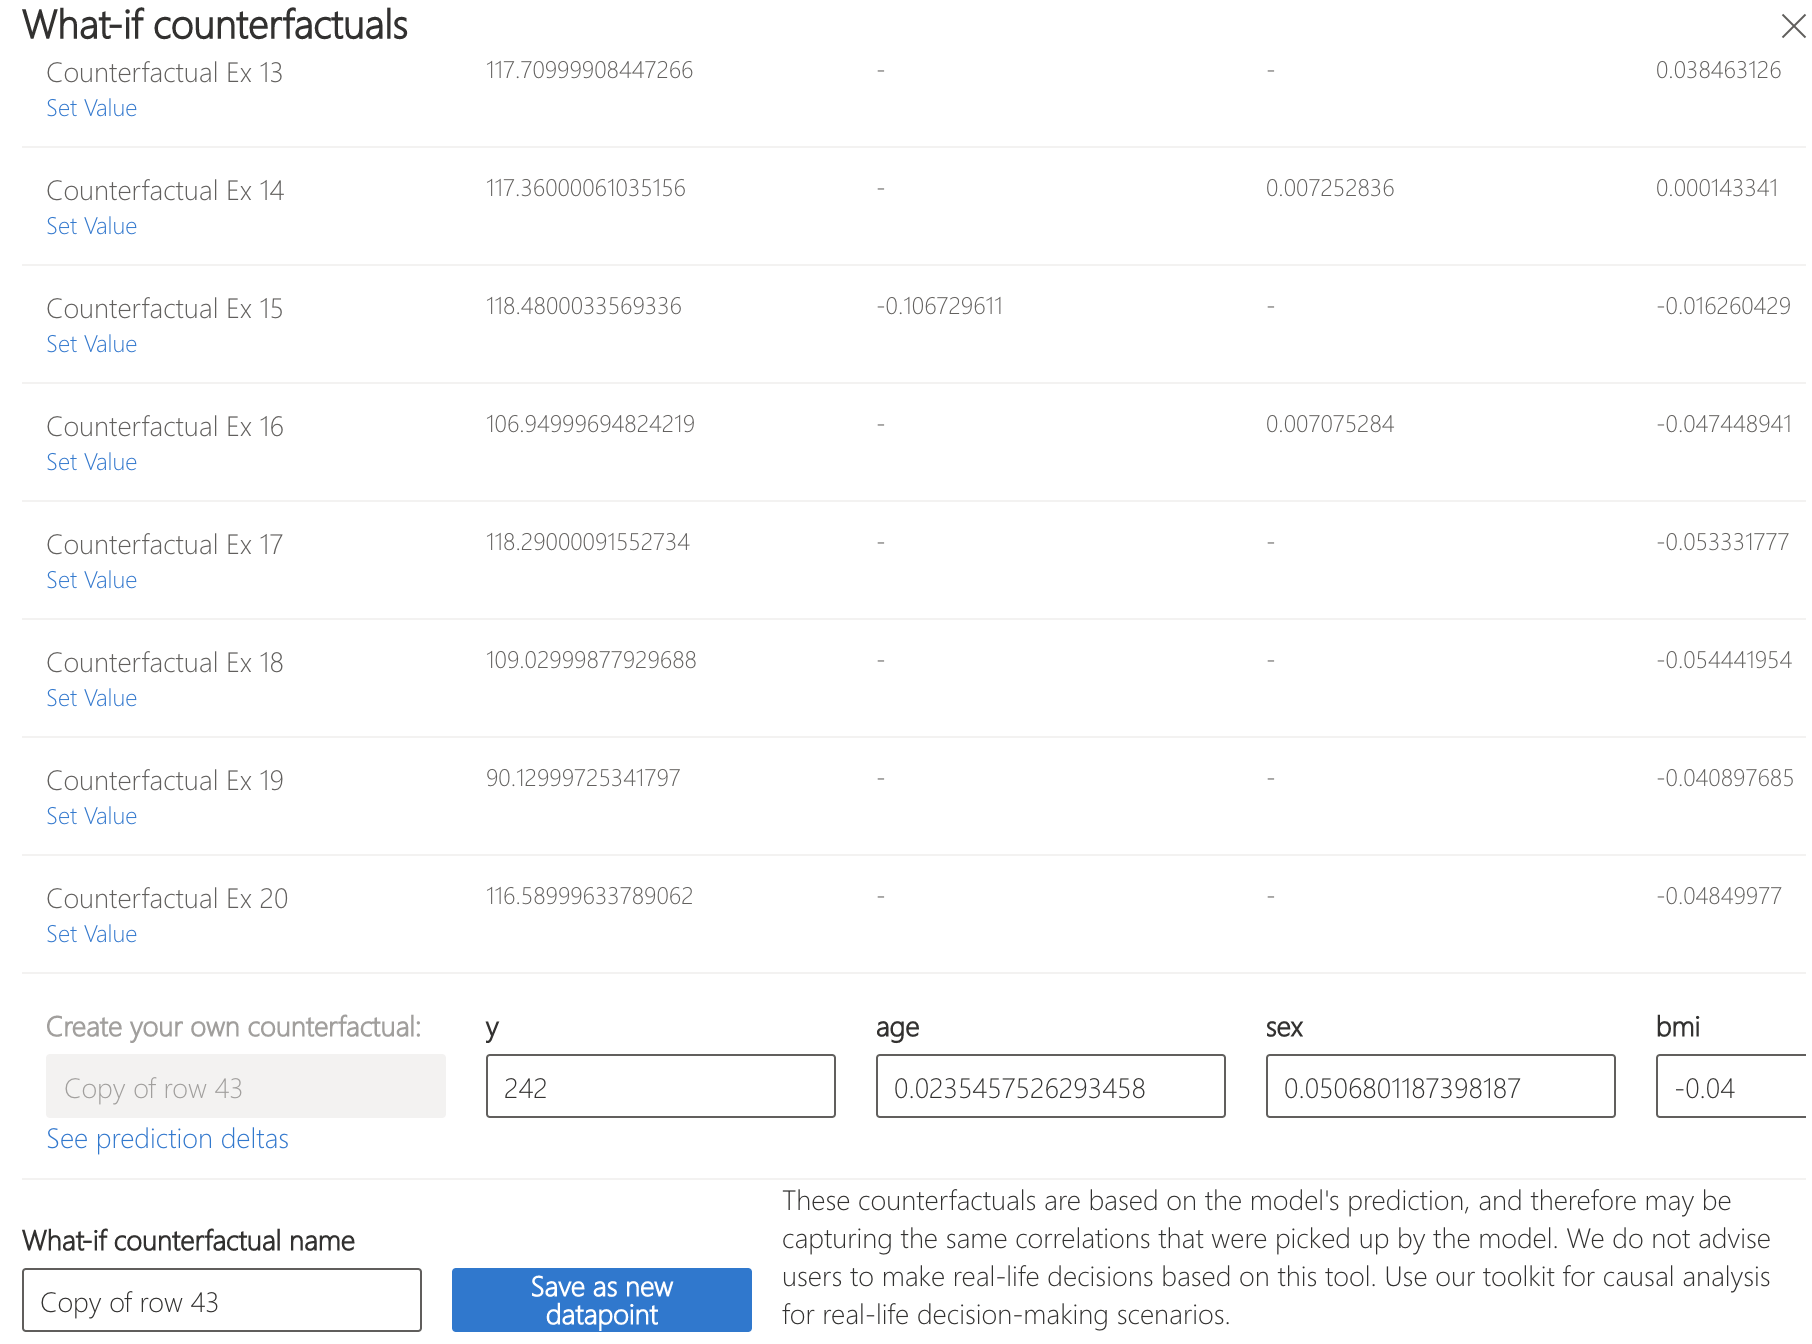

As we can see, the model's prediction has dropped to 131.22. Thus, Patient 43 should work on reducing their [body mass index and serum triglycerides level](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) to bring the model score under the insurance threshold.

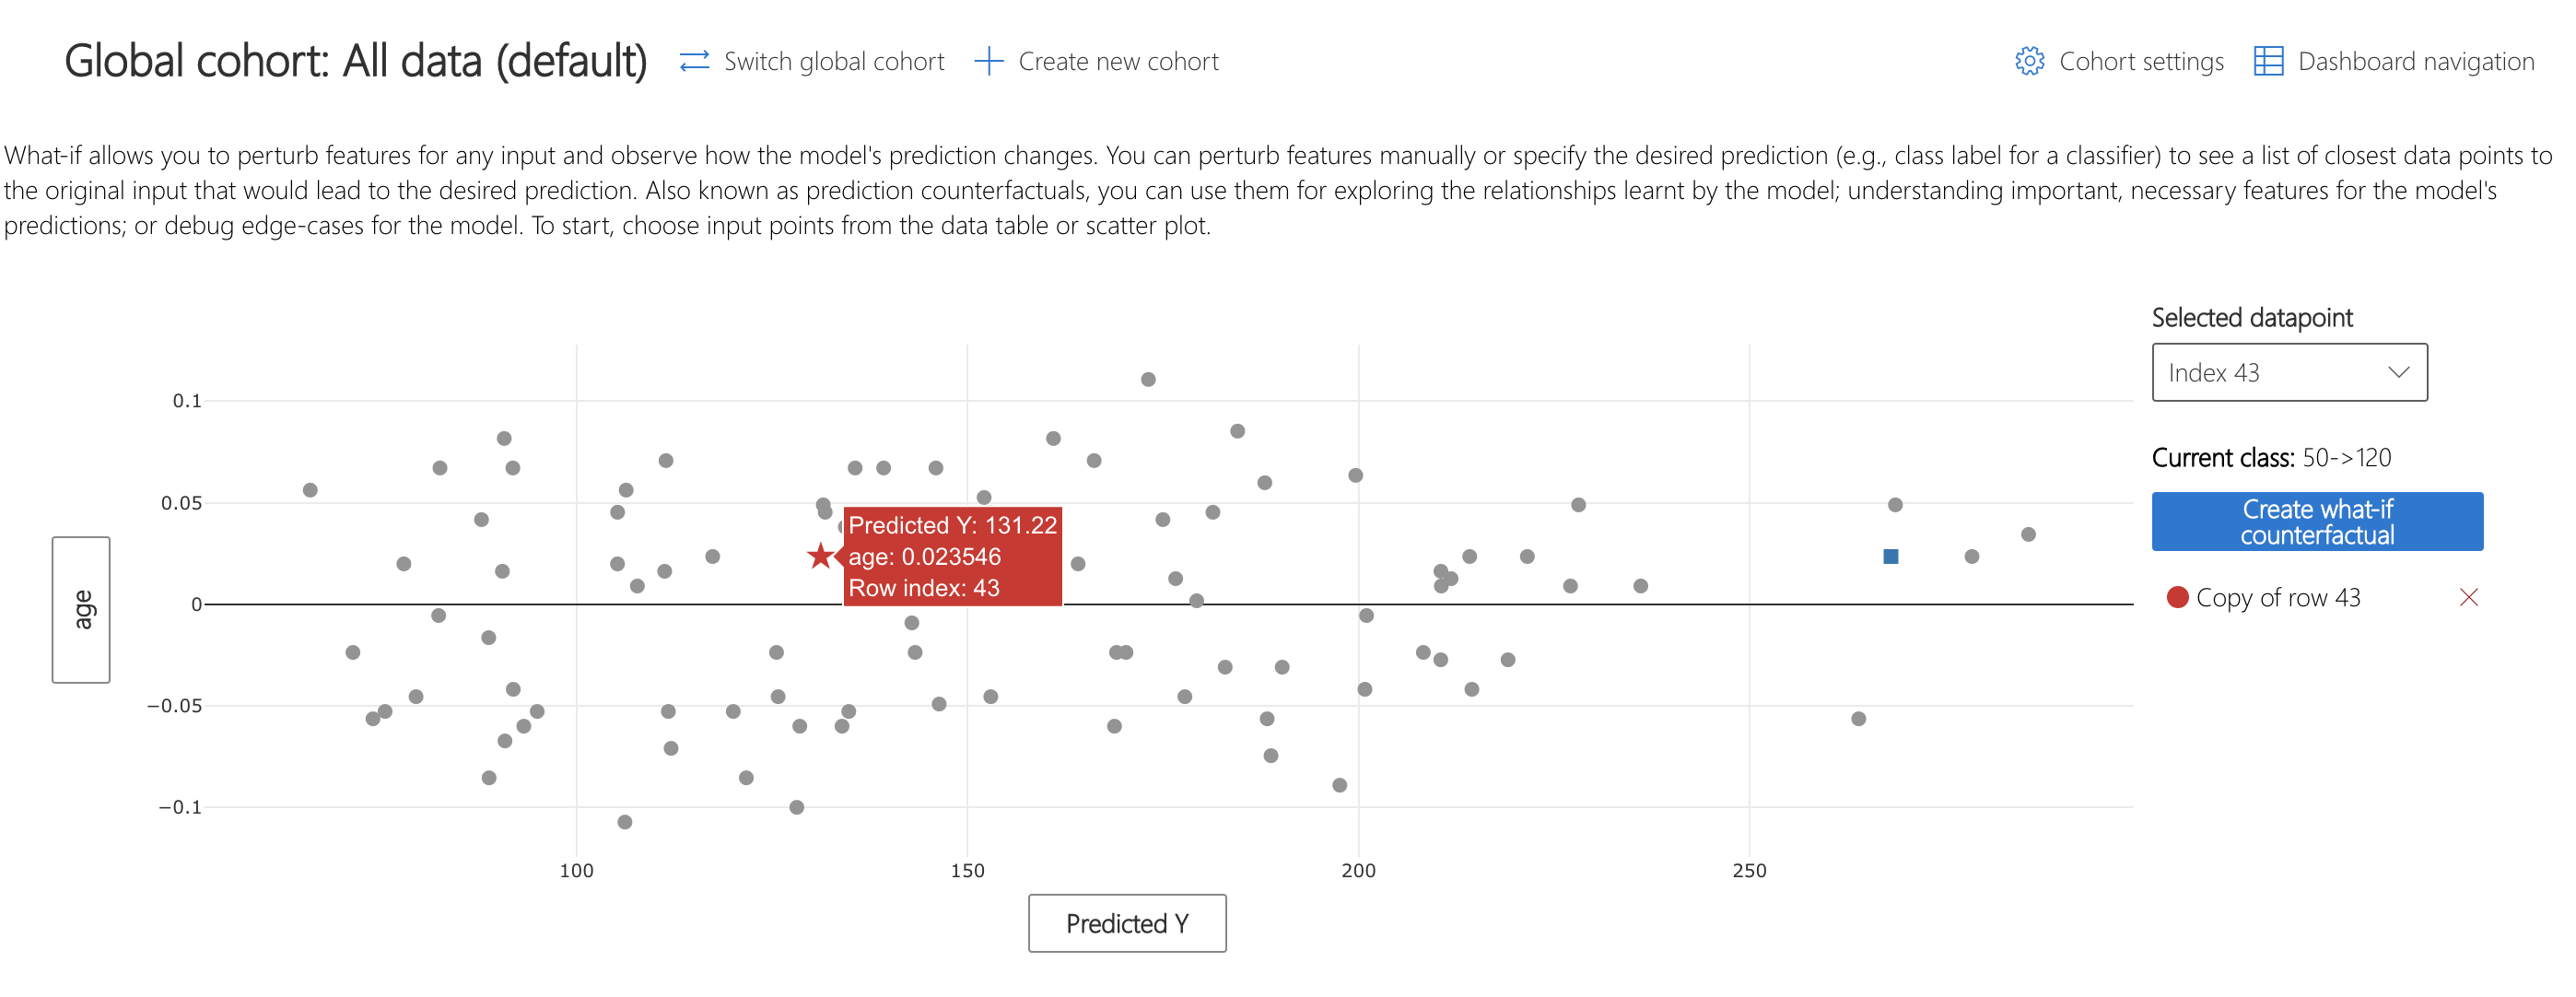

Note that this result does not mean that reducing `bmi` and `s5` *causes* the diabetes progression score to go down. It simply decreases the model prediction. To investigate causal relationships, continue reading:

### Causal Analysis

Now suppose that a doctor wishes to know how to reduce the progression of diabetes in her patients. This can be explored in the Causal Inference component of the Responsible AI Toolbox.

In the "Aggregate causal effects" tab, it is possible to see how perturbing features causes lower disease progression. It appears that increasing s2 (LDL) by one unit, would increase diabetes progression by 606.89 units.

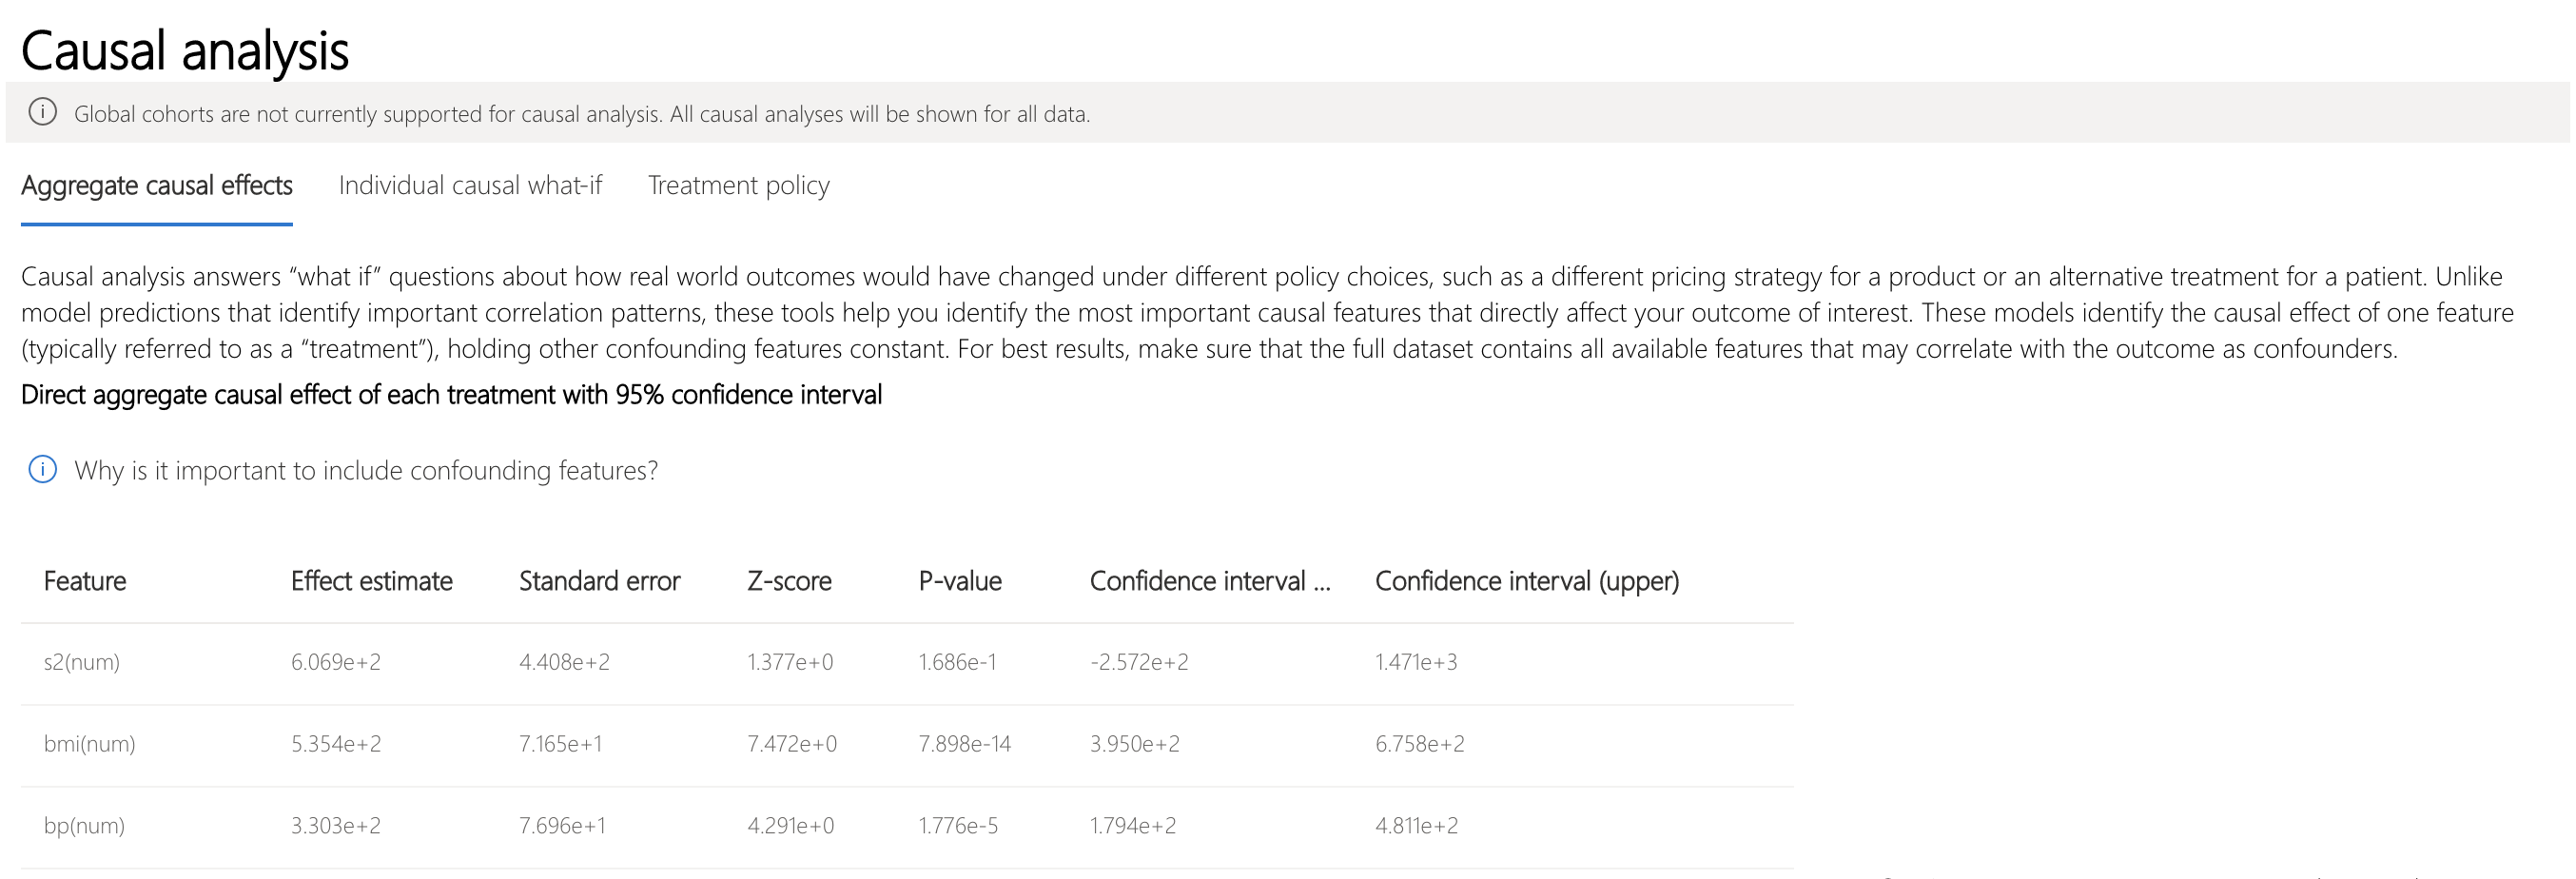
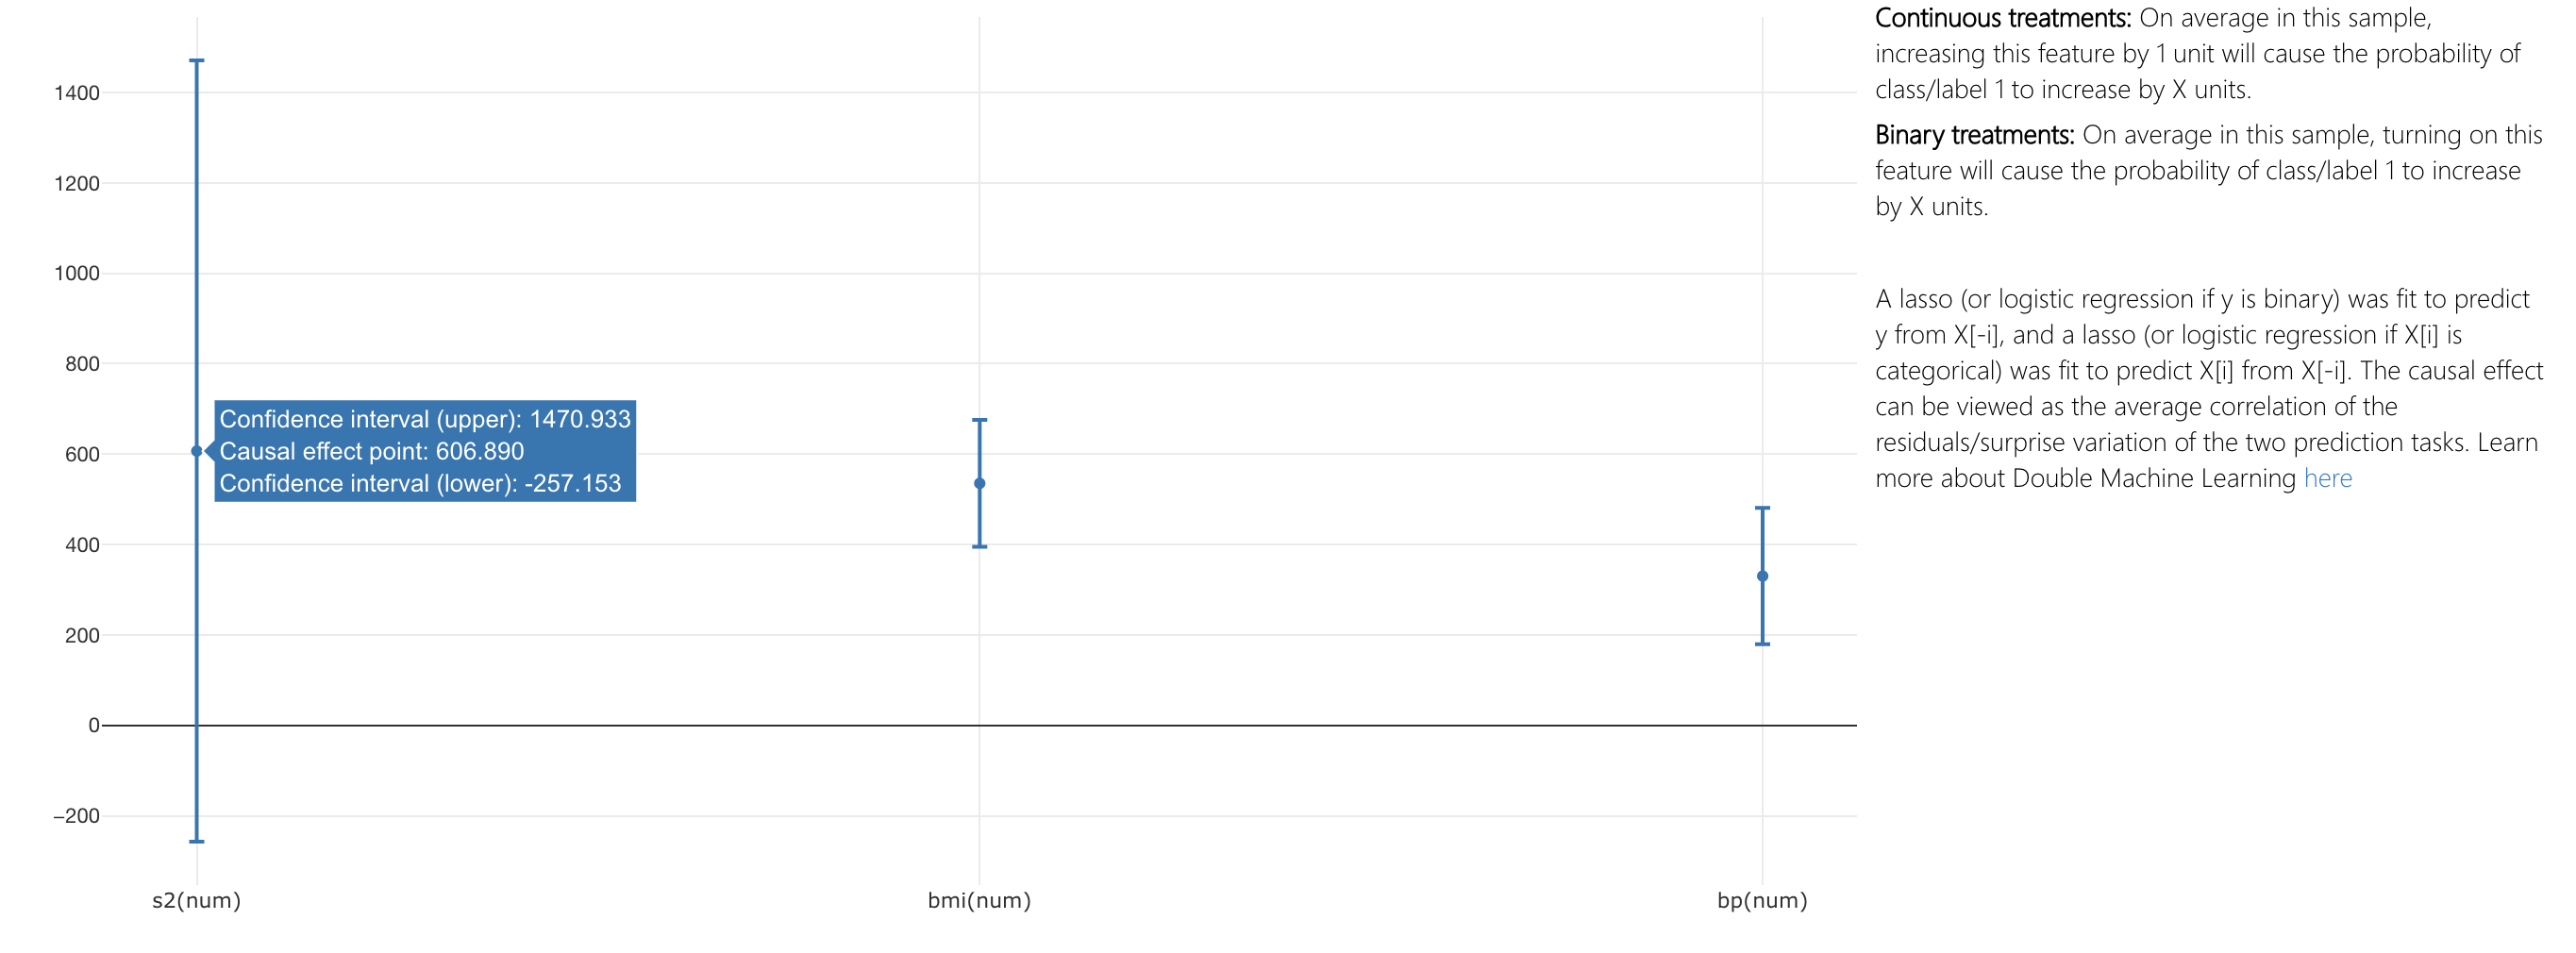

Let's revisit Patient 43. Instead of simply reducing the model score, they've decided to focus on actually improving their health to manage their diabetes better. In the "Individual causal what-if" tab, it shows that decreasing his/her bmi to 0.05 reduces diabetes progression from 242 to 237.982.

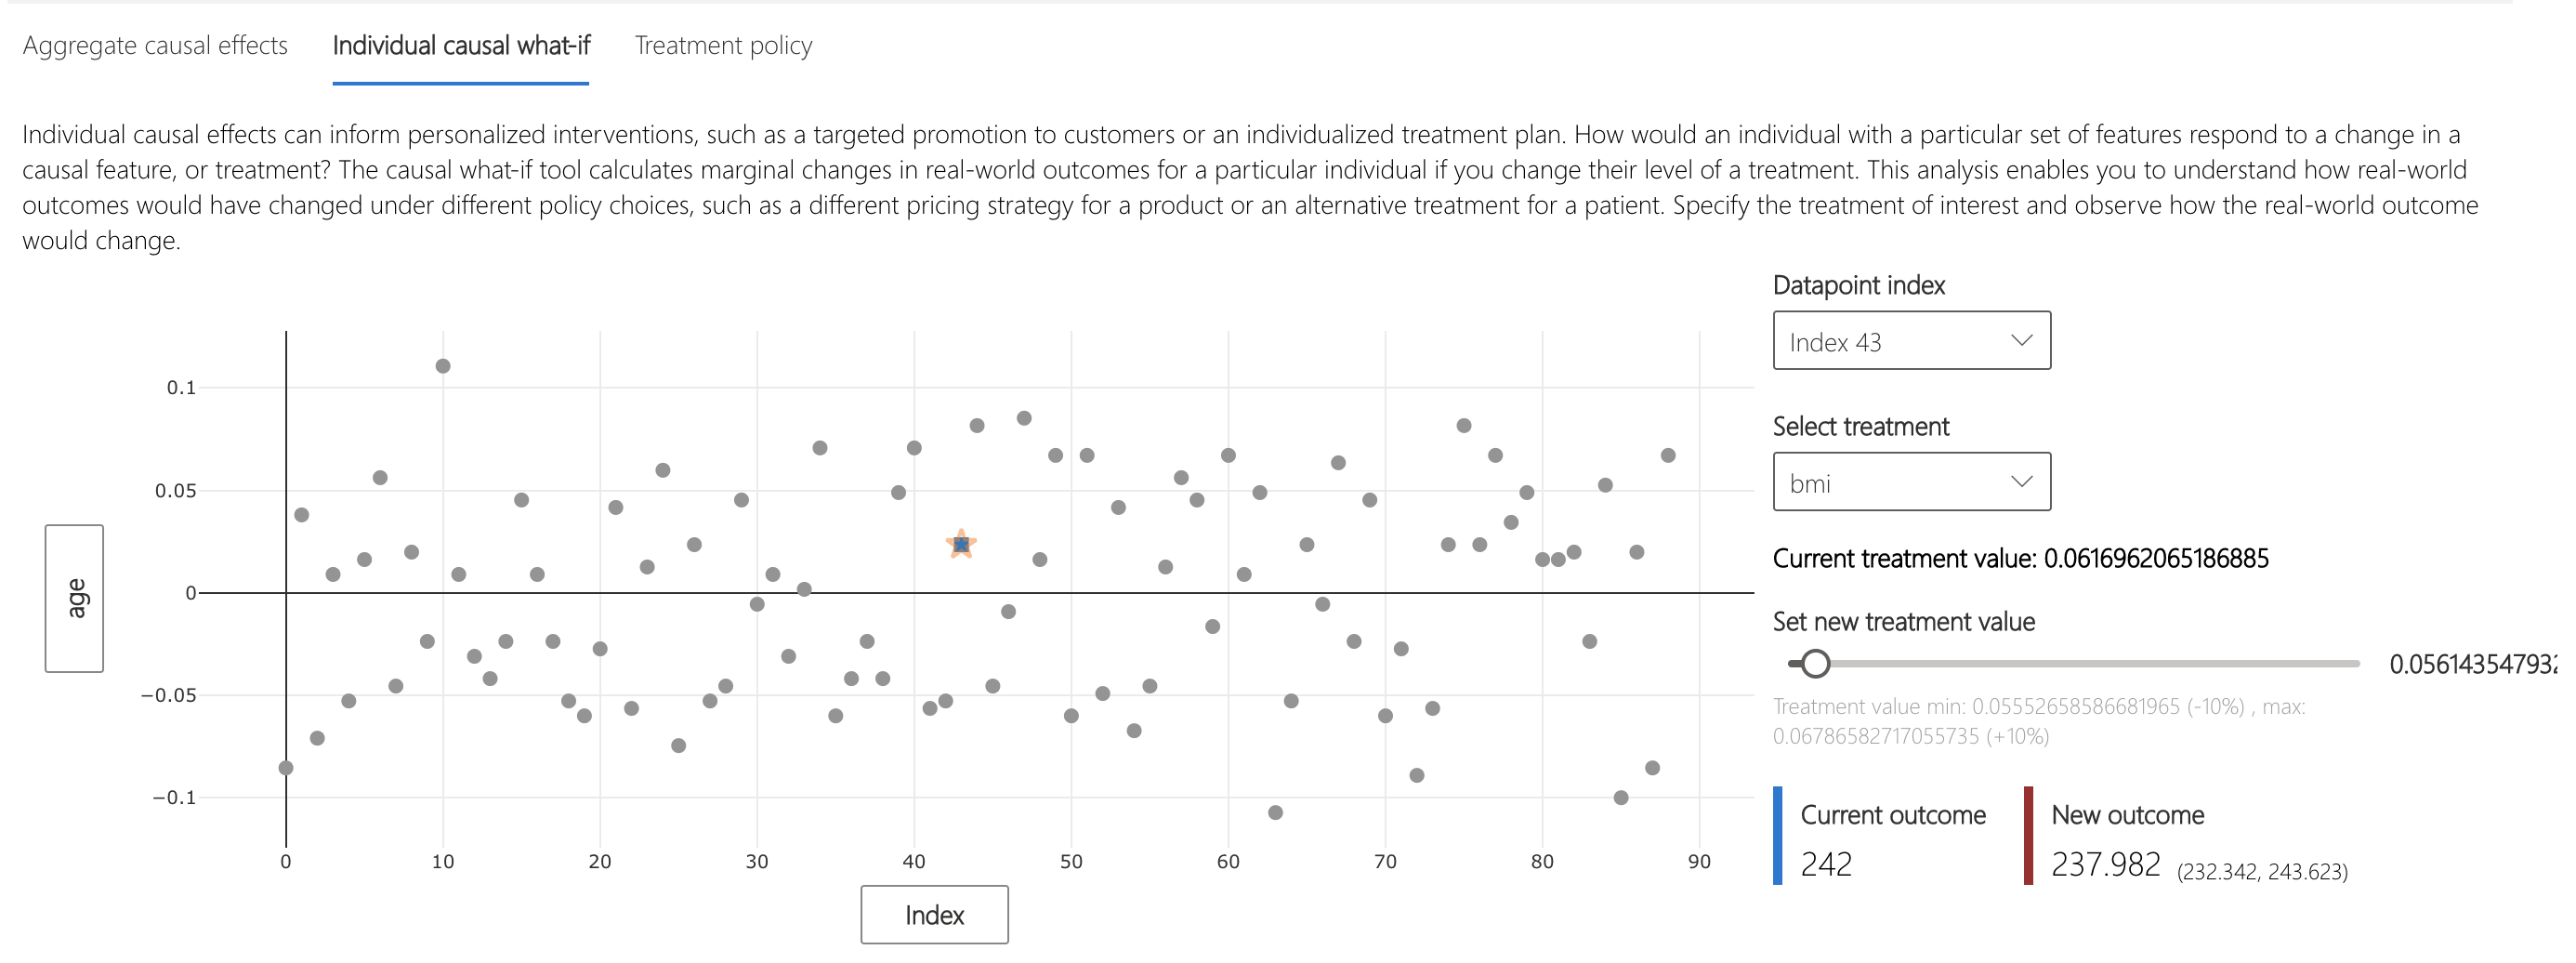

To put that into a formal intervention policy, switch to the "Treatment policy" tab. This view helps build policies for future interventions. You can identify what parts of your sample experience the largest responses to changes in causal features, or treatments, and construct rules to define which future populations should be targeted for particular interventions.

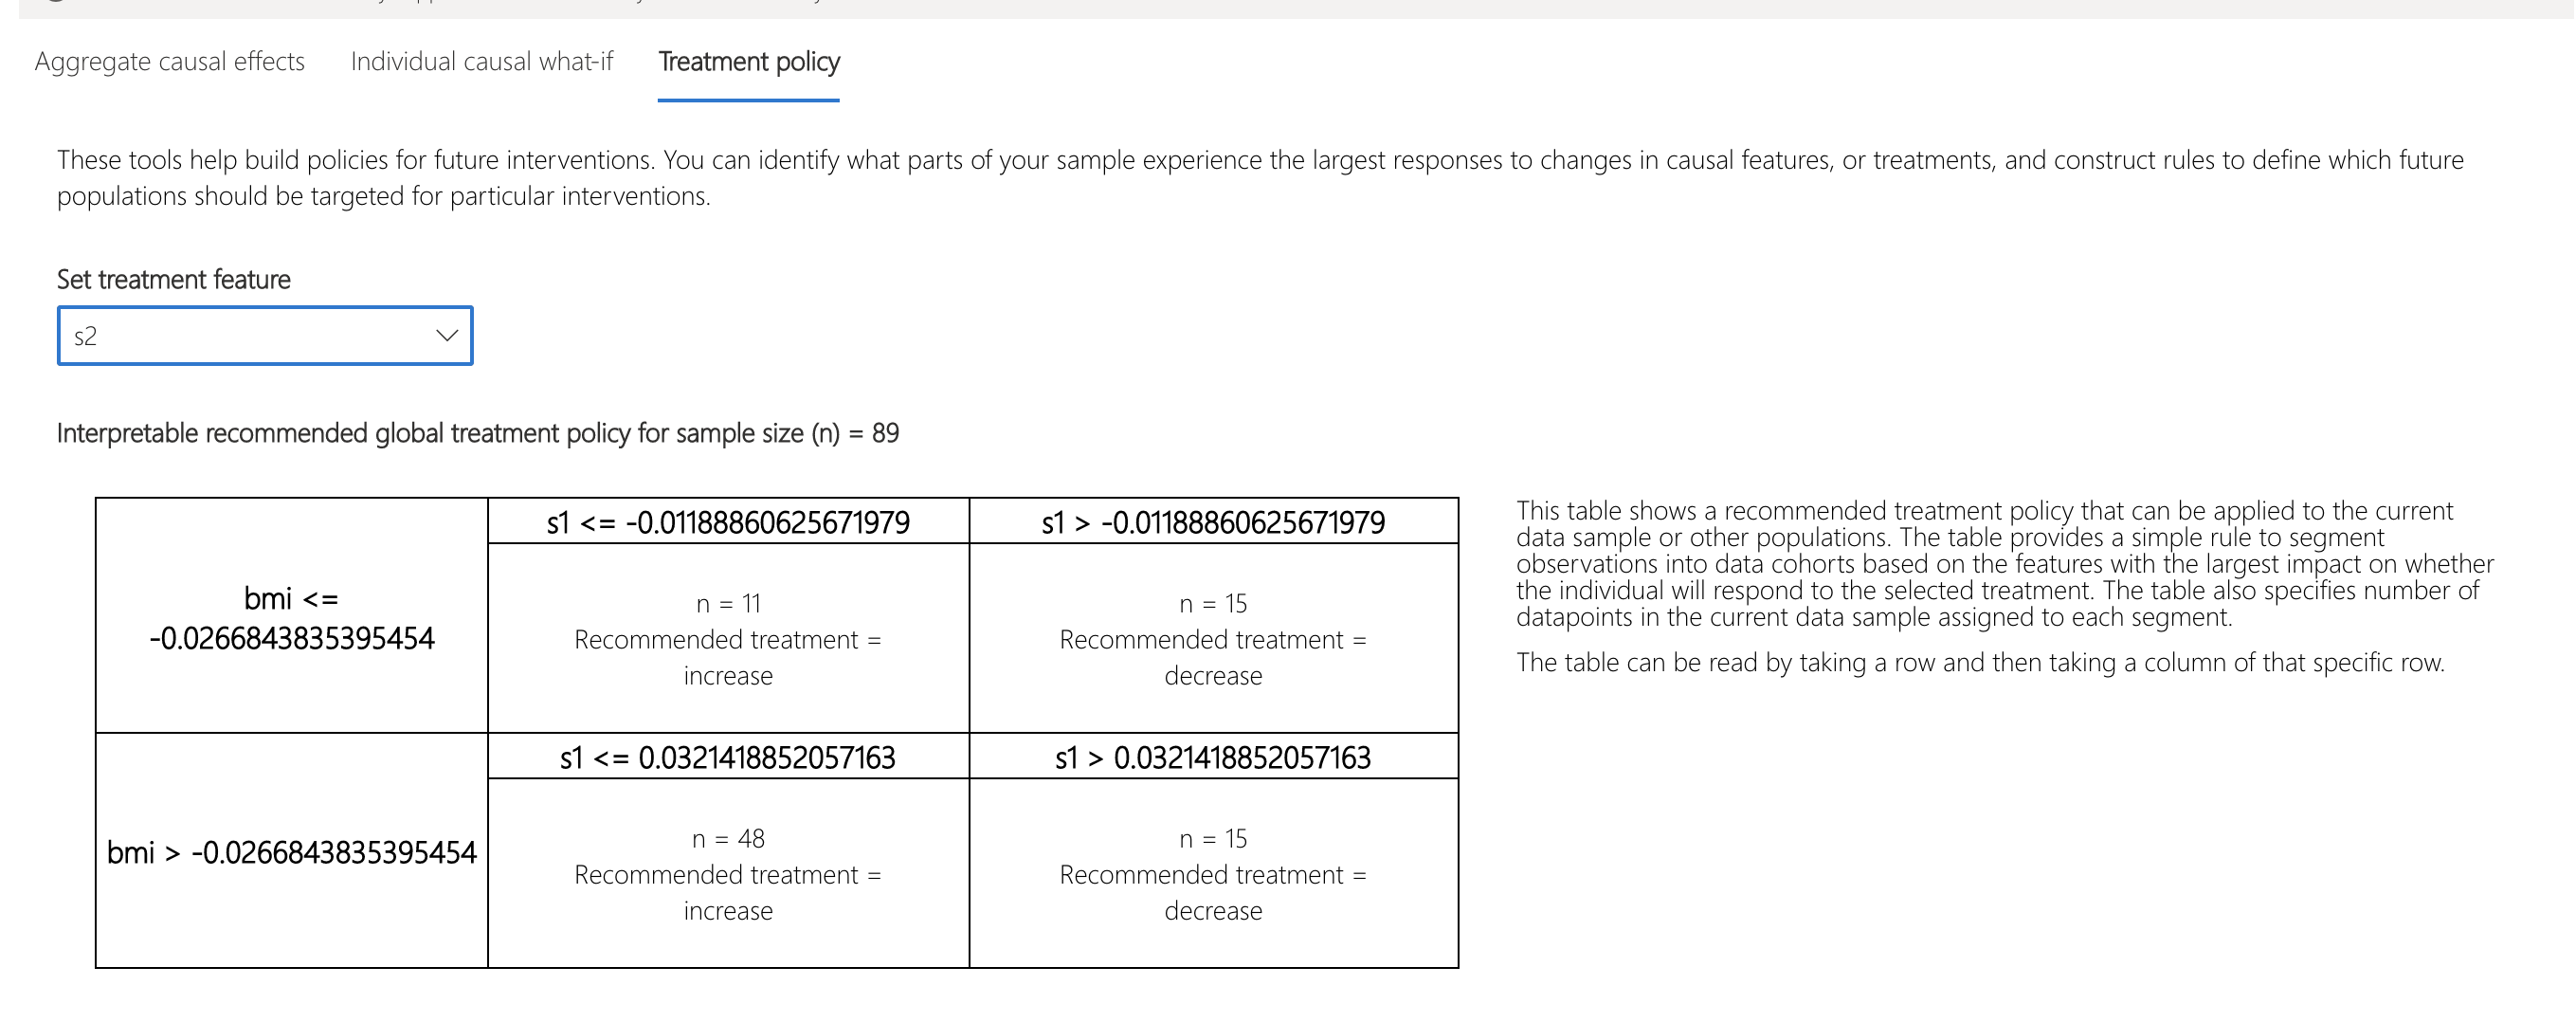

Is that change the best overall treatment for them? Let's investigate different policies. Going back to the "Treatment policy" tab, we see that going with the above intervention of s2 feature outperforms perturbing that  with a "always increase" intervention.

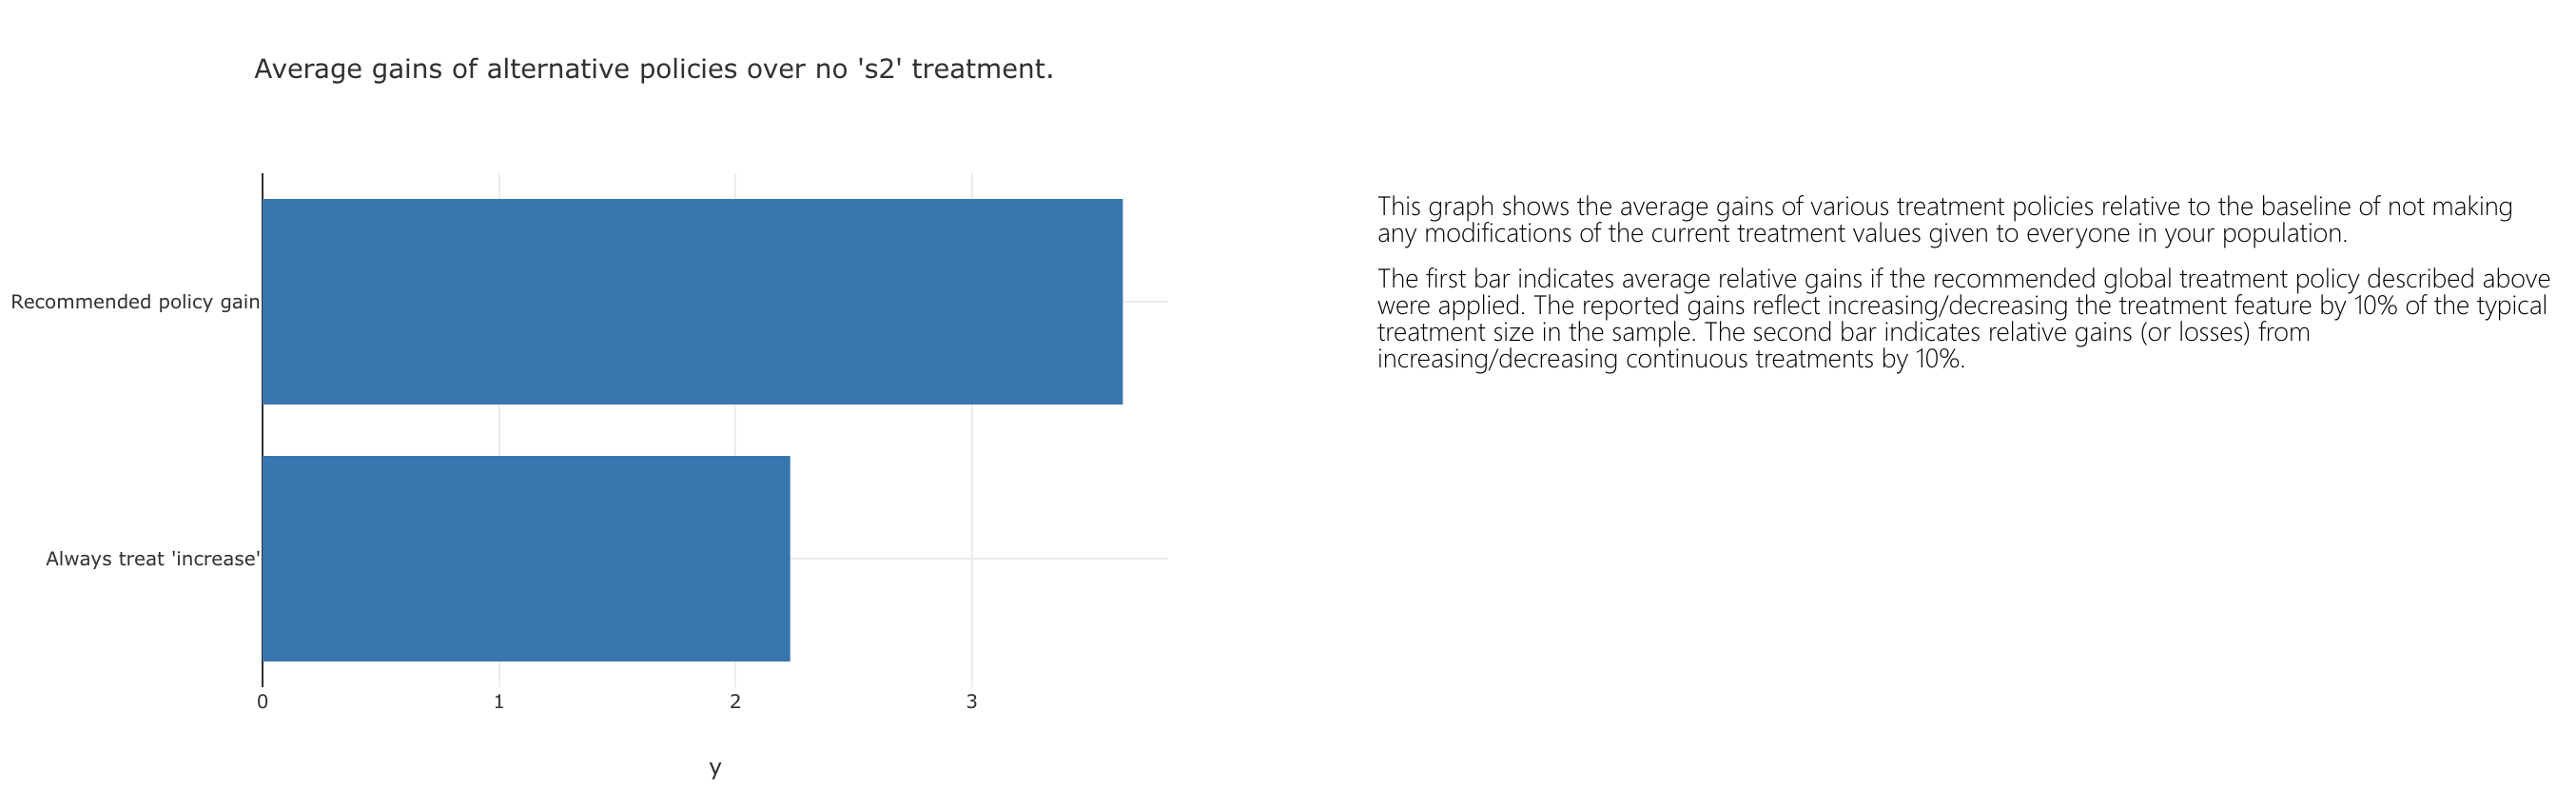

Finally, you can see a list demonstrating which datapoints (patients) in the current data sample have the largest causal response to the selected treatment (s2 feature change), based on all features included in the estimated causal model.

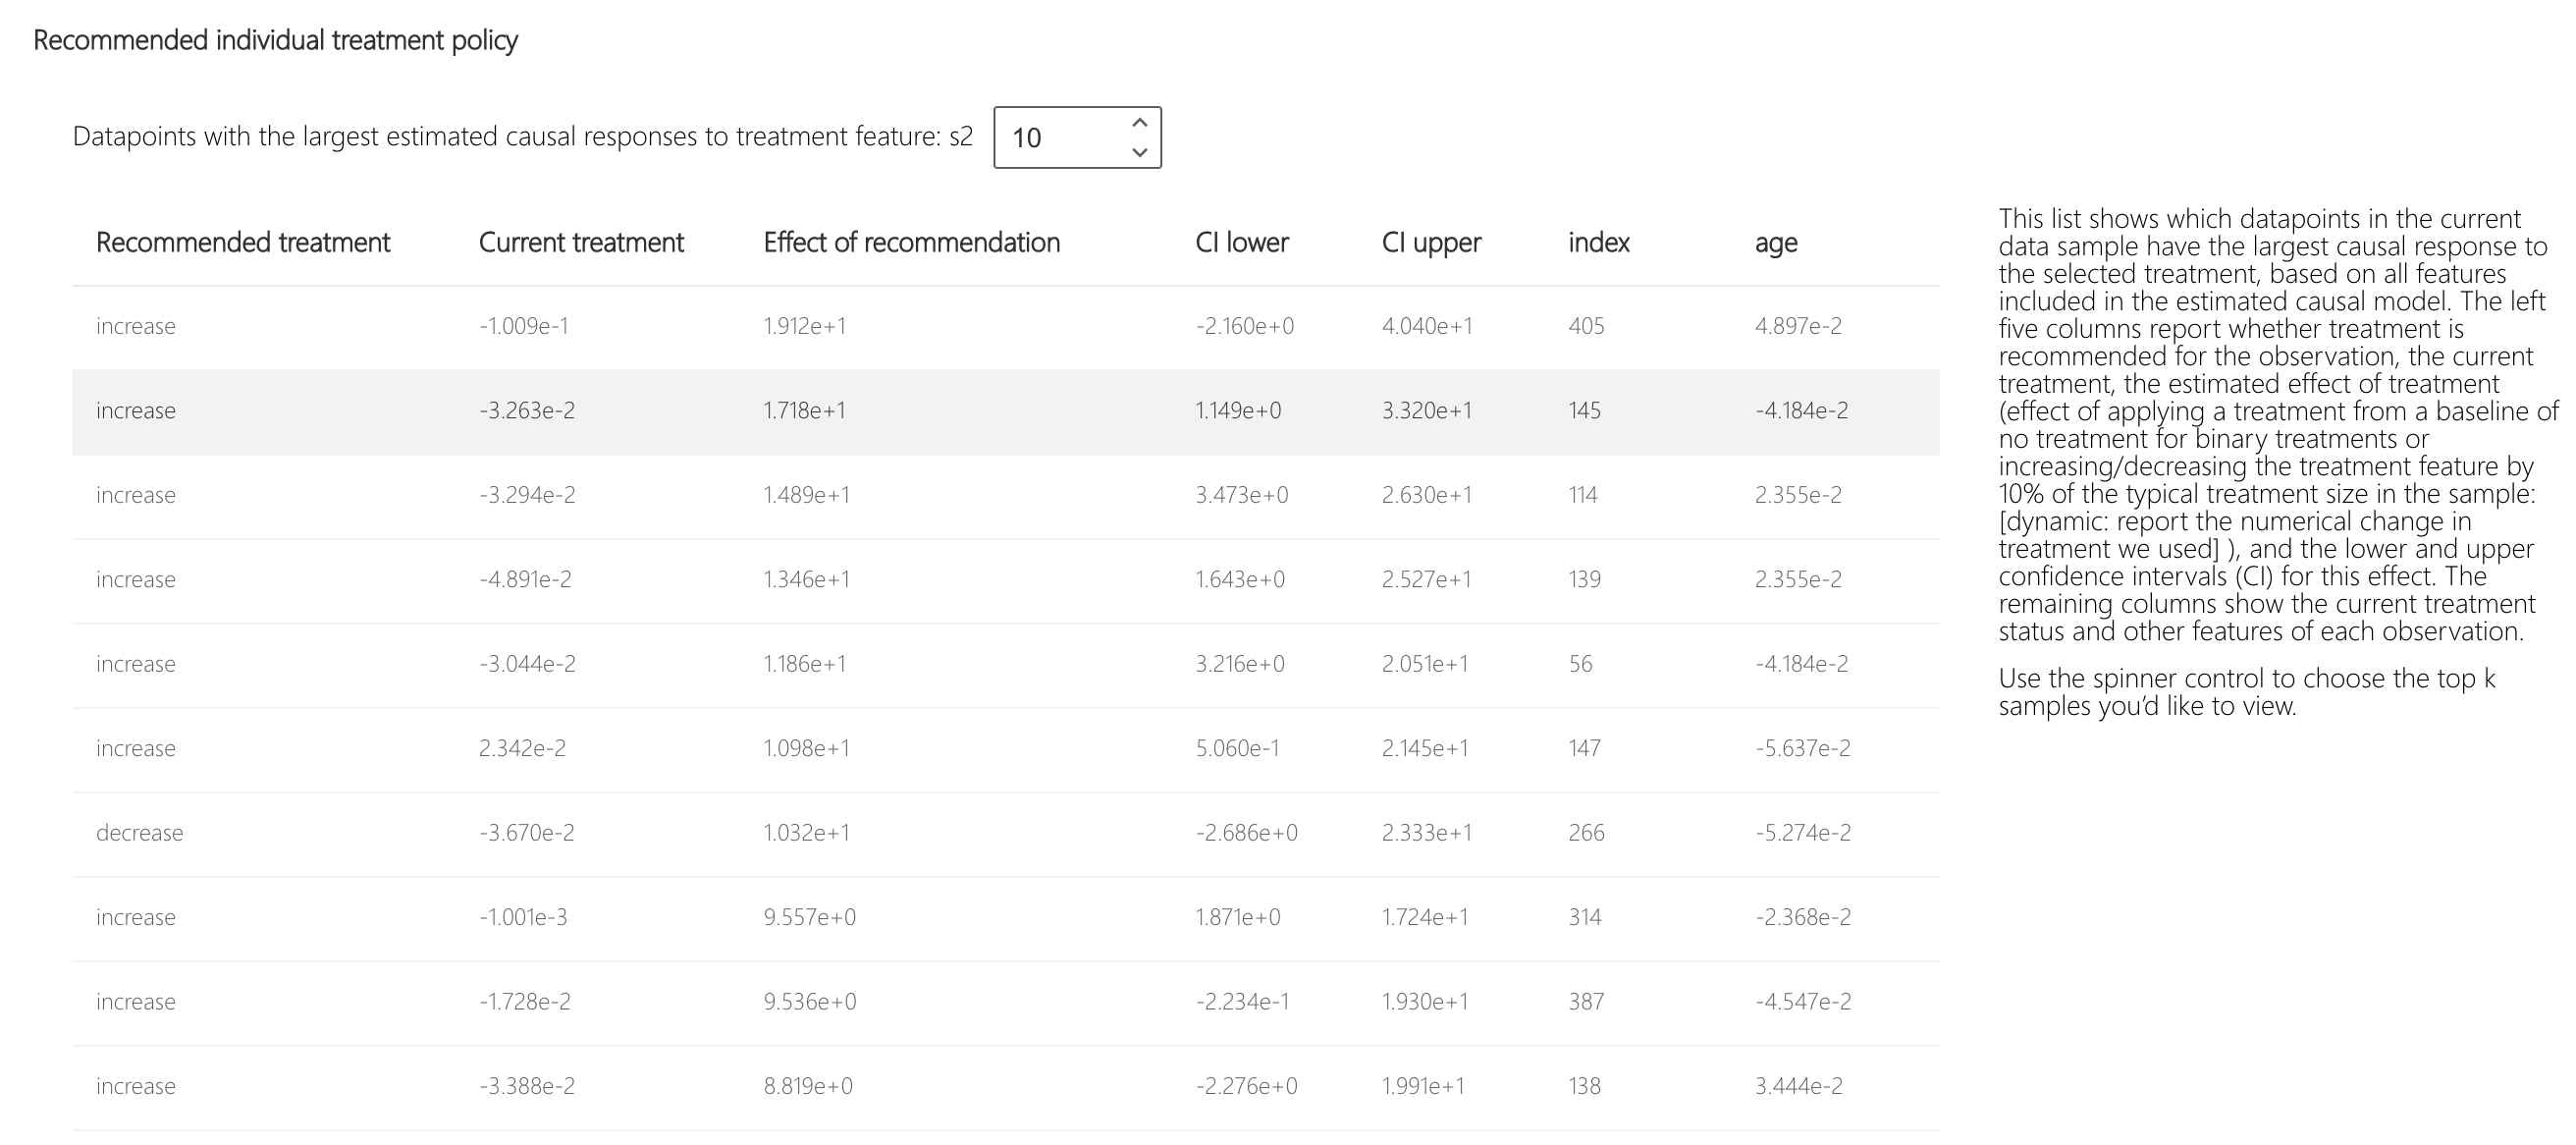